# Dimensionality reduction through Principal Component Analysis

Principal component analysis can be stated as a dimensionality reduction task – find a hyperplane such that the sum of distance squares is minimal. The latter is equivalent to the following data generation model:

* True data $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n$ exists on a low-dimensional hyperplane.
* Observed data $\boldsymbol{y}_1,\ldots,\boldsymbol{y}_n$ lies on a higher-dimensional space due to random perturbations $\boldsymbol{\varepsilon}_1,\ldots,\boldsymbol{\varepsilon}_n$.
* We assume that these perturbations $\boldsymbol{\varepsilon}_1,\ldots,\boldsymbol{\varepsilon}_n$ are independent and come from a spherical normal distribution.

There are two ways this model can be extended:

* We can model the perturbations with different sperical distributions, such as spherical Laplace distribution. Such an approach would be justified when there are many outliers – normal distribution has light tails and is thus much more sensitive to extreme outliers than the Laplace distribution.

* We can model the underlying surface differently. For instance, we can assume that the original data comes from a curve or a surface. The resulting learning tasks are known as principal curve and principal surface reconstruction. For example, a multi-touch device must solve a principal curve problem near real-time to get a good user experience in drawing.  

We use images and their colorspaces to illustrate basic concepts of dimensionality reduction, as many images have reduced colorspace and the steps done during hyperplane reconstruction are easily interpretable.
Since the colorspace is inherently three-dimensional we use the package `ipyvolume` for making three-dimensional plots interactive. Further details about this package can be obtained from the following sources:

* [Ipyvolume documentation](https://ipyvolume.readthedocs.io/en/latest/)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Youtube](https://www.youtube.com/watch?v=hOKa8klJPyo)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Jupyter Notebook](https://github.com/maartenbreddels/talk-ipyvolume-scipy2018/blob/master/ipyvolume-presentation.ipynb)


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

# Tools for 3D visualisation
import ipyvolume as ipv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

# Tools for PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# Standard stuff
from pandas import Series
from pandas import DataFrame
from tqdm import tnrange#, tqdm_notebook
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Image sampling and processing functions

Before we can proceed to colorspace manipulation we need a couple of functions to process raw images.
Note that images will be represented as $m\times n\times 3$ `numpy` array `img` where 
* the first channel `img[:,:, 0]` encodes the intensity of reds (R)
* the second channel `img[:,:, 1]` encodes the intensity of greens (G)
* the third channel `img[:,:, 1]` encodes the intensity of blues (B)

Note that there are alternatives to RGB representation such as HSL and HSV with [well-established conversion formulae](https://en.wikipedia.org/wiki/HSL_and_HSV) from which we use some bits and pieces.

### Colorspace formation

In [2]:
def image_to_colorspace(image: np.array, sample_count: int = None) -> DataFrame:
    """
    Reorders the m x n image to (n * n) x 3 matrix where each row corresponds to single pixel.
    
    If sample_count is set then only random subset of rows is returned. 
    """
    
    if sample_count:
        return DataFrame({'R':image[:,:,0].flatten(),'G':image[:,:, 1].flatten(),'B':image[:,:, 2].flatten()}).sample(n = sample_count, replace=False)
    else: 
        return DataFrame({'R':image[:,:,0].flatten(),'G':image[:,:, 1].flatten(),'B':image[:,:, 2].flatten()})

To make our life easier we also need an inverse transformation that arranges the colorspace back to the image.

In [3]:
def colorspace_to_image(cspace: DataFrame, m: int, n: int) -> np.array:
    assert len(cspace) == m * n, 'Dimensions must match'
    assert all(cspace.columns.values == ['R', 'G', 'B']), 'Columns must match'
    
    result = np.empty([m,n,3])
    result[:,:, 0] = cspace['R'].values.reshape(m, n)
    result[:,:, 1] = cspace['G'].values.reshape(m, n)
    result[:,:, 2] = cspace['B'].values.reshape(m, n)
    return result

### Luminocity based grayscale conversion

In [4]:
def convert_to_grayscale(image: np.array)-> np.array:
    """Converts RGB image to grayscale image preserving perceived luminocity based on Y_601 formula""" 
    return 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]

## II. Visual inspection of tonality of different paintings

The painings of Pablo Picasso that come from a blue and rose period have an exceptional RGB spectrum and thus are good examples for dimensionality reduction.

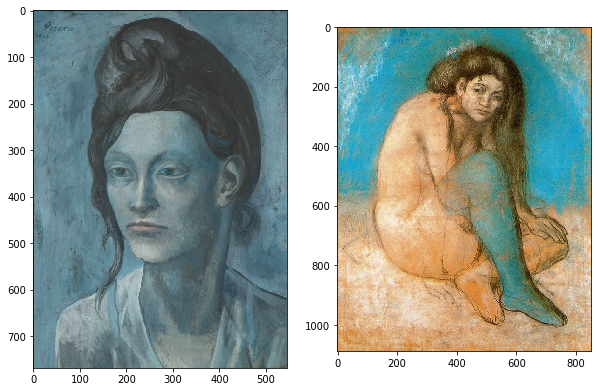

In [5]:
pink_image = plt.imread('data/colorspace/picasso_nude_with_crossed legs_1903.png')
blue_image = plt.imread('data/colorspace/picasso_woman_with_a_helmet_of_hair_1904.png')

fig=plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(blue_image)
fig.add_subplot(1, 2, 2)
plt.imshow(pink_image)

### Colorspace of Woman with a Helmet of Hair

The colorspace of the blue image is almost a one-dimensional line. 

In [6]:
fig = ipv.figure()
blue_cs = image_to_colorspace(blue_image, 10000)
scatter = ipv.scatter(blue_cs.loc[:, 'R'].values, blue_cs.loc[:, 'G'].values, blue_cs.loc[:, 'B'].values, color = blue_cs.values, s = 0.5, marker='sphere')
ipv.show()

### Colorspace of Nude with Crossed Legs

The colorspace of the pink image is clearly a two-dimensional surface which is quite flat and can be approximated with a hyperplane. 

In [7]:
fig = ipv.figure()
pink_cs = image_to_colorspace(pink_image, 10000)
scatter = ipv.scatter(pink_cs.loc[:, 'R'].values, pink_cs.loc[:, 'G'].values, pink_cs.loc[:, 'B'].values, color = pink_cs.values, s = 0.5, marker='sphere')
ipv.show()

## III. Dimensionality reduction with PCA

### Helper functions

In [8]:
def reduced_0d_colorspace(mu: np.array, k = 30) -> np.array:
    """
    Returns an a k x k image in the mean color
    
    mu   --- mean color 
    k    --- number of colors 
    """
    
    result = np.full([k, k, 3], np.nan)
    for j in range(k):
            result[:, j, :] = mu 
    
    return result

In [9]:
def reduced_1d_colorspace(mu: np.array, pca: np.array, d:float = 0.3, k = 30) -> np.array:
    """
    Returns an image of available colors in reduced one-dimensional colorspace
    
    mu   --- mean color 
    pca  --- principal color 
    d    --- maximal value of xi coefficients
    k    --- number of colors
    """
    
    Xi = np.linspace(-d, d, k)
    result = np.full([k, k, 3], np.nan)
    for j, xi in enumerate(Xi):
            result[:, j, :] = mu + pca * xi
    
    return result

In [10]:
def reduced_2d_colorspace(mu: np.array, pca1: np.array, pca2: np.array, d:float = 0.3, k = 30) -> np.array:
    """
    Returns a k x k image of available colors in reduced two-dimensional colorspace
    
    mu   --- mean color 
    pca1 --- the first principal color 
    pca2 --- the second principal color
    d    --- maximal value of xi coefficients
    k    --- number of colors
    """
    
    Xi1 = np.linspace(-d, d, k)
    Xi2 = np.linspace(-d, d, k)
    result = np.full([k, k, 3], np.nan)
    for i, xi1 in enumerate(Xi1):
        for j, xi2 in enumerate(Xi2):
            result[i, j, :] = mu + pca1 * xi1 + pca2 * xi2
    
    return result

### Woman with a Helmet of Hair

Principal component analysis of the blue picture reveals the following parameters.

In [11]:
pca = PCA()
pca.fit(blue_cs)

W = DataFrame(pca.components_, columns = ['R', 'G', 'B'], index = ['PCA1', 'PCA2', 'PCA3'])
Lambda = DataFrame(pca.explained_variance_, columns=['lambda'], index = ['PCA1', 'PCA2', 'PCA3'])
rel_var = DataFrame(100*pca.explained_variance_ratio_, columns = ['variance'], index = ['PCA1', 'PCA2', 'PCA3'])
mu = DataFrame(pca.mean_, index = ['R', 'G', 'B']).T

mdisplay([Lambda.reset_index(),W.reset_index(), mu, Lambda.reset_index(), rel_var.reset_index(), ], 
         ['Loadings', 'Rotation matrix', 'Mean color', 'Explained absolute variance', 'Explained relative variance'])

Loadings Rotation matrix Mean color Explained absolute variance Explained relative variance 
 
 
 index 
 lambda 
 
 
 
 
 PCA1 
 0.041588 
 
 
 PCA2 
 0.001567 
 
 
 PCA3 
 0.000036 
 
 
 
 
 
 index 
 R 
 G 
 B 
 
 
 
 
 PCA1 
 0.473470 
 0.603717 
 0.641367 
 
 
 PCA2 
 0.835245 
 -0.076567 
 -0.544522 
 
 
 PCA3 
 0.279630 
 -0.793513 
 0.540504 
 
 
 
 
 
 R 
 G 
 B 
 
 
 
 
 0.365307 
 0.454 
 0.477513 
 
 
 
 
 
 index 
 lambda 
 
 
 
 
 PCA1 
 0.041588 
 
 
 PCA2 
 0.001567 
 
 
 PCA3 
 0.000036 
 
 
 
 
 
 index 
 variance 
 
 
 
 
 PCA1 
 96.289673 
 
 
 PCA2 
 3.627271 
 
 
 PCA3 
 0.083053

These parameters have the following interpretations.

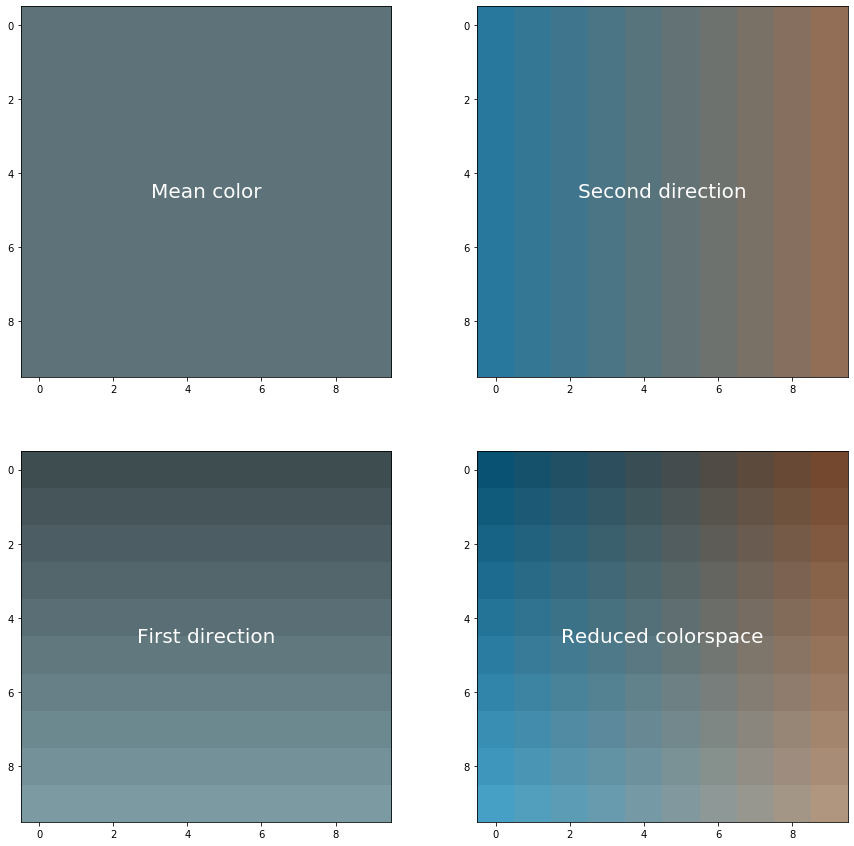

In [12]:
k = 10
d = 0.25
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(reduced_0d_colorspace(mu, k=k))
plt.text((k-1)/2, (k-1)/2, 'Mean color', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(222)
plt.imshow(reduced_1d_colorspace(mu, W.loc['PCA2', :], d=d, k=k))
plt.text((k-1)/2, (k-1)/2, 'Second direction', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(223)
plt.imshow(np.transpose(reduced_1d_colorspace(mu, W.loc['PCA1', :], d=d, k=k), axes = [1,0,2]))
plt.text((k-1)/2, (k-1)/2, 'First direction', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(224)
plt.imshow(reduced_2d_colorspace(mu, W.loc['PCA1', :], W.loc['PCA2', :], d=d, k=k))
plt.text((k-1)/2, (k-1)/2, 'Reduced colorspace', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
None

### Nude with Crossed Legs

Principal component analysis of the blue picture reveals the following parameters.

In [13]:
pca = PCA()
pca.fit(pink_cs)

W = DataFrame(pca.components_, columns = ['R', 'G', 'B'], index = ['PCA1', 'PCA2', 'PCA3'])
Lambda = DataFrame(pca.explained_variance_, columns=['lambda'], index = ['PCA1', 'PCA2', 'PCA3'])
rel_var = DataFrame(100*pca.explained_variance_ratio_, columns = ['variance'], index = ['PCA1', 'PCA2', 'PCA3'])
mu = DataFrame(pca.mean_, index = ['R', 'G', 'B']).T

mdisplay([Lambda.reset_index(),W.reset_index(), mu, Lambda.reset_index(), rel_var.reset_index(), ], 
         ['Loadings', 'Rotation matrix', 'Mean color', 'Explained absolute variance', 'Explained relative variance'])

Loadings Rotation matrix Mean color Explained absolute variance Explained relative variance 
 
 
 index 
 lambda 
 
 
 
 
 PCA1 
 0.088841 
 
 
 PCA2 
 0.046661 
 
 
 PCA3 
 0.000337 
 
 
 
 
 
 index 
 R 
 G 
 B 
 
 
 
 
 PCA1 
 -0.904849 
 -0.385386 
 -0.180904 
 
 
 PCA2 
 0.351861 
 -0.437752 
 -0.827386 
 
 
 PCA3 
 0.239671 
 -0.812312 
 0.531702 
 
 
 
 
 
 R 
 G 
 B 
 
 
 
 
 0.576558 
 0.593497 
 0.491038 
 
 
 
 
 
 index 
 lambda 
 
 
 
 
 PCA1 
 0.088841 
 
 
 PCA2 
 0.046661 
 
 
 PCA3 
 0.000337 
 
 
 
 
 
 index 
 variance 
 
 
 
 
 PCA1 
 65.402130 
 
 
 PCA2 
 34.350140 
 
 
 PCA3 
 0.247732

These parameters have the following interpretations.

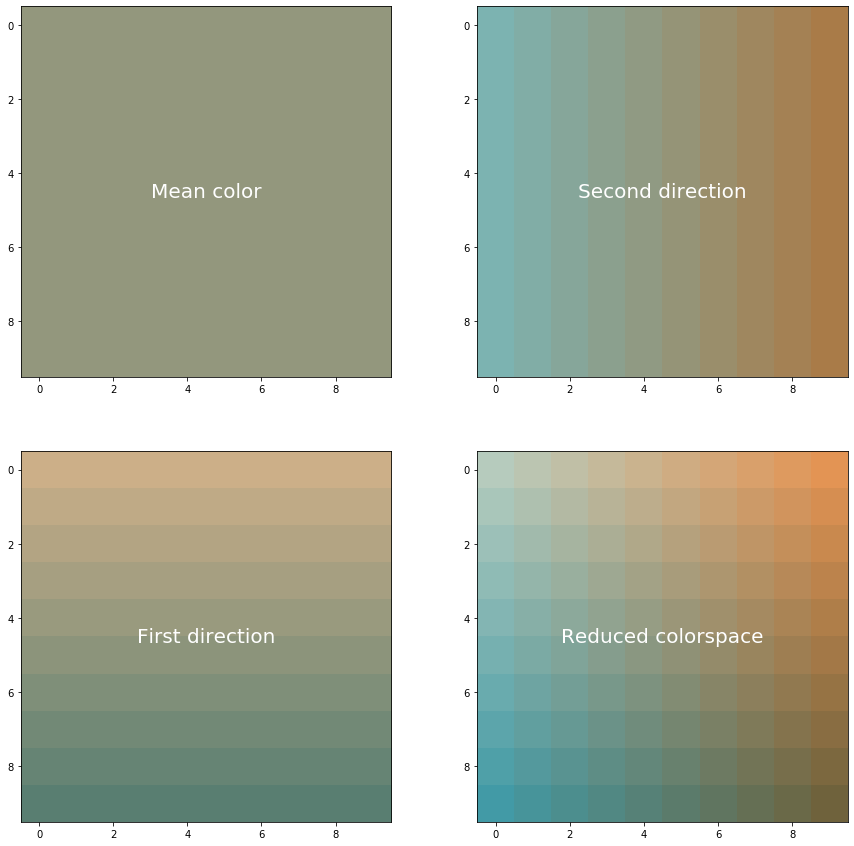

In [14]:
k = 10
d = 0.25
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(reduced_0d_colorspace(mu, k=k))
plt.text((k-1)/2, (k-1)/2, 'Mean color', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(222)
plt.imshow(reduced_1d_colorspace(mu, W.loc['PCA2', :], d=d, k=k))
plt.text((k-1)/2, (k-1)/2, 'Second direction', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(223)
plt.imshow(np.transpose(reduced_1d_colorspace(mu, W.loc['PCA1', :], d=d, k=k), axes = [1,0,2]))
plt.text((k-1)/2, (k-1)/2, 'First direction', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
plt.subplot(224)
plt.imshow(reduced_2d_colorspace(mu, W.loc['PCA1', :], W.loc['PCA2', :], d=d, k=k))
plt.text((k-1)/2, (k-1)/2, 'Reduced colorspace', horizontalalignment='center', verticalalignment='center', color='white', fontsize=20)
None

### Images reduced to two-dimensional colorspace

By using transform and inverse transform we can reduce the image to a more compact colorspace. This makes colors less vibrant but as the third principal component of Woman with a Helmet of Hair explains only $0.08\%$ of the overall variability in the data, we should see no difference. 
For Nude with Crossed Legs the change is a bit more pronounced but still negligible as just $0.25\%$ of the variance is captured by the third component.

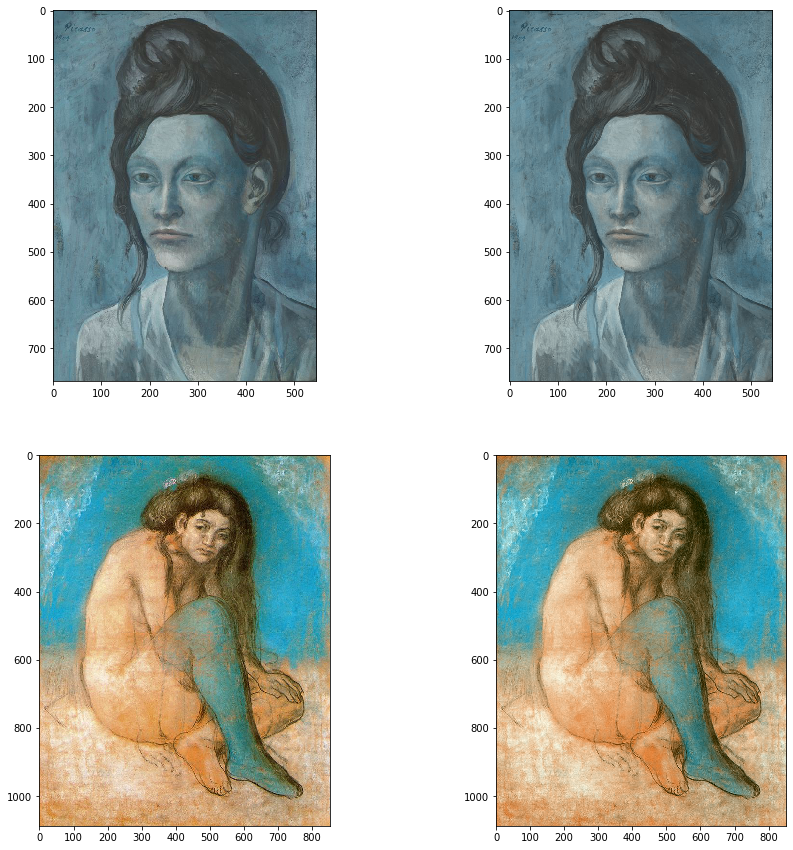

In [15]:
y_blue = image_to_colorspace(blue_image)
m_blue, n_blue, _ = blue_image.shape

pca.fit(blue_cs)
mu_blue = pca.mean_
xi_blue = pca.transform(y_blue)
xi_blue[:, 2] = 0
x_blue = DataFrame(np.clip(pca.inverse_transform(xi_blue), 0, 1), columns = ['R', 'G', 'B'])

y_pink = image_to_colorspace(pink_image)
m_pink, n_pink, _ = pink_image.shape

pca.fit(pink_cs)
mu_pink = pca.mean_
xi_pink = pca.transform(y_pink)
xi_pink[:, 2] = 0
x_pink = DataFrame(np.clip(pca.inverse_transform(xi_pink), 0, 1), columns = ['R', 'G', 'B'])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(blue_image)
plt.subplot(222)
plt.imshow(colorspace_to_image(x_blue, m_blue, n_blue))
plt.subplot(223)
plt.imshow(pink_image)
plt.subplot(224)
plt.imshow(colorspace_to_image(x_pink, m_pink, n_pink))

### Images reduced to one-dimensional colorspace

We can further reduce the image colorspace to a one-dimesional line. This time the change is visible as the second and third principal components of Woman with a Helmet of Hair explain $3.68\%$ of the variance. 
For Nude with Crossed Legs the change is even more pronounced as $34.2\%$ of the variance is captured by the second and third components.
Nevertheless, note that individual details of the paintings are still clearly recognisable and thus most image processing and machine learning algorithms would still provide the same results.  

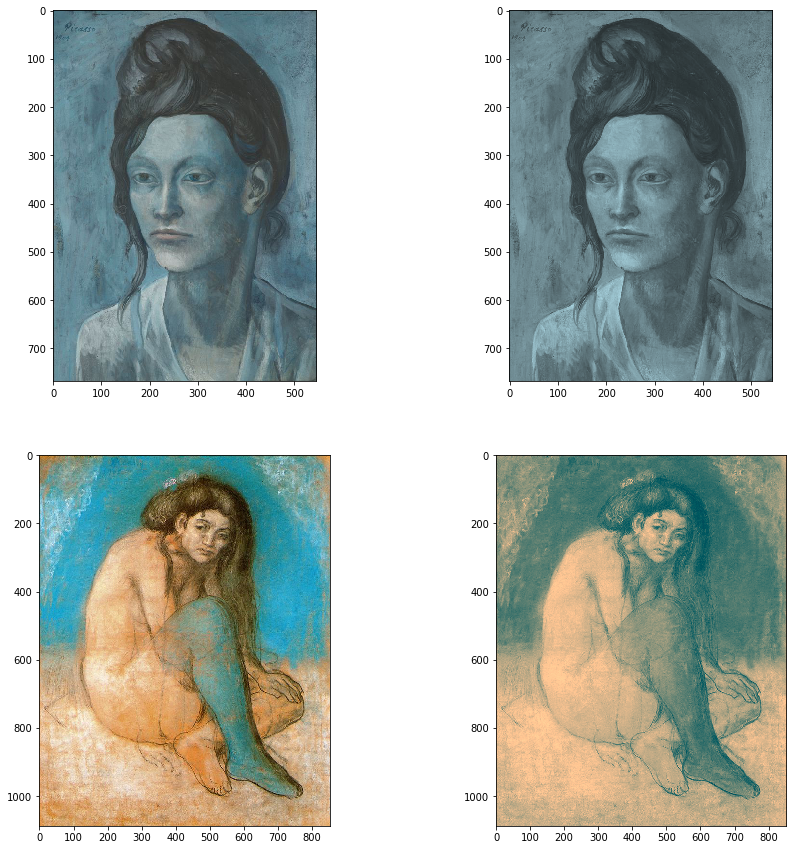

In [16]:
pca.fit(blue_cs)
mu_blue = pca.mean_
xi_blue = pca.transform(y_blue)
xi_blue[:, 2] = 0
xi_blue[:, 1] = 0
x_blue = DataFrame(np.clip(pca.inverse_transform(xi_blue), 0, 1), columns = ['R', 'G', 'B'])

pca.fit(pink_cs)
mu_pink = pca.mean_
xi_pink = pca.transform(y_pink)
xi_pink[:, 2] = 0
xi_pink[:, 1] = 0
x_pink = DataFrame(np.clip(pca.inverse_transform(xi_pink), 0, 1), columns = ['R', 'G', 'B'])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(blue_image)
plt.subplot(222)
plt.imshow(colorspace_to_image(x_blue, m_blue, n_blue))
plt.subplot(223)
plt.imshow(pink_image)
plt.subplot(224)
plt.imshow(colorspace_to_image(x_pink, m_pink, n_pink))

### Change of tonality through change of principle components

By default, PCA does not return scaled $\boldsymbol{\xi}$ coordinates, i.e., their covariance matrix is not an identity matrix. However, we can force it by setting the `whiten` flag. As a result, the PCA will find a transformation

\begin{align*}
\boldsymbol{\xi} = W (\boldsymbol{y}-\boldsymbol{\mu})  
\end{align*}

such that $\boldsymbol{\xi}$ is white Gaussian noise. If we pipe this back to the inverse transformation of another PCA transformation, we get a distribution that has the same parameters as the original. To be punctual, this is true only if the second PCA transformation is learned on top of a multivariate normal distribution, otherwise there are some discrepancies. 

Nevertheless, the resulting cumulative distribution is quite close and thus the tonality is more or less matched. This allows us to convert the blue period to the rose period and vice versa. The results are not good as we only match the colorspace but completely ignore the spatial features.

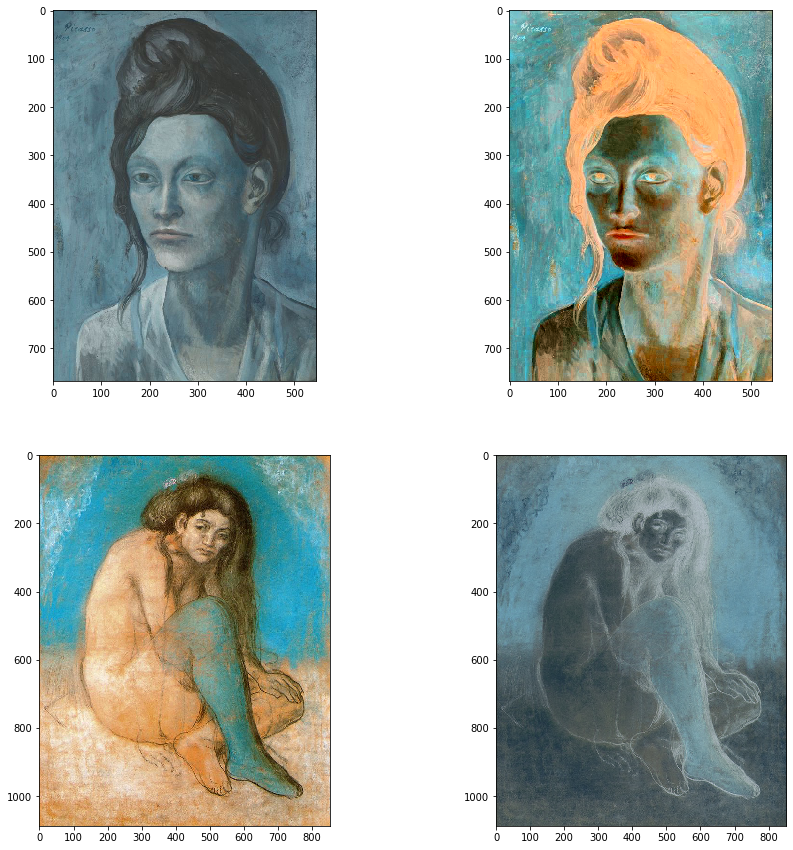

In [17]:
pca_blue = PCA(whiten=True)
pca_blue.fit(blue_cs)
xi_blue = pca_blue.transform(y_blue)

pca_pink = PCA(whiten=True)
pca_pink.fit(pink_cs)
xi_pink = pca_pink.transform(y_pink)

z_blue = DataFrame(np.clip(pca_pink.inverse_transform(xi_blue), 0, 1), columns = ['R', 'G', 'B'])
z_pink = DataFrame(np.clip(pca_blue.inverse_transform(xi_pink), 0, 1), columns = ['R', 'G', 'B'])

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(blue_image)
plt.subplot(222)
plt.imshow(colorspace_to_image(z_blue, m_blue, n_blue))
plt.subplot(223)
plt.imshow(pink_image)
plt.subplot(224)
plt.imshow(colorspace_to_image(z_pink, m_pink, n_pink))

# Homework

## 2.1 Dimensionality reduction algorithm (<font color='red'>2p</font>) 

This exercise explores how principal component analysis can be used for dimensionality reduction. Assume that the actual data $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_m$ is located in a low-dimensional space or curve but our observations $\boldsymbol{y}_1,\ldots,\boldsymbol{y}_m$ are shifted due to white Gaussian noise.
* Generate the data located on a straight line specified by the following parametrised equation:

\begin{align*}
\begin{cases}
 x_1 &= t\enspace,\\
 x_2 &= 2t\enspace,\\
 x_3 &= 3 - t\enspace.
\end{cases}
\end{align*}

For instance, sample the value of $t$ uniformly $500$ times from the range $[0,1]$ and add white Gaussian noise $\varepsilon_1,\varepsilon_2,\varepsilon_3\sim\mathcal{N}(0,0.1)$. Visualise the original data and disturbed data using `ipyvolume.scatter`.

* Use the function `PCA` to find the principal components of the data. Since the original data is one-dimensional, use the first coordinate of the PCA and the first principal component to reduce the data to a one-dimensional object. Compare the reconstructed line with the original line. Are they well aligned? Visualise also the distance between the original data points and reconstructed data points. Compare it with the distance between the original data points and observed data points. Use histograms for that. What is the main reason that the data is not completely reconstructed and how precise the reconstruction is on average? 

* Generate the data located on a plane specified by a parametrised equation
\begin{align*}
\boldsymbol{x}=t_1\boldsymbol{p}_1+t_2\boldsymbol{p}_2
\end{align*}
where $\boldsymbol{p}_1=(1,1,1)^T$ and $\boldsymbol{p}_2=(0,1,-1)^T$. Again, generate $500$ data points on the plane and add white Gaussian noise $\varepsilon_1,\varepsilon_2,\varepsilon_3\sim\mathcal{N}(0,0.1)$. Visualise the original data and disturbed data using `ipyvolume.scatter` plots.
Reconstruct the plane using PCA. Again, estimate the reconstruction precision by comparing the distance distributions between the original, reconstructed and observed data.

## Two-dimensional projection of the colorspace (<font color='red'>1p</font>)

In the tutorial we showed the datapoints as a three-dimensional cloud. This is not good for printing. As the data for these colorspaces is almost flat you can adequately represent the color distances by considering the first two coordinates of the PCA reduction. Draw a two-dimensional color cloud where the points are in the original color and slightly translucent.